## Importazione 

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U --pre segmentation-models

In [2]:
import segmentation_models as sm

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
import cv2
import tensorflow as tf
import keras
#import tensorflow.keras
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH_BASE = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/npy_files/'
MODELS_PATH = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/h5_files/'

# Load X/Y test e codebook

In [0]:
dataset_splitted_nneigh_pad_augm = np.load(PATH_BASE + "dataset_splitted_nneigh_pad_augm.npz")

In [0]:
x_test = dataset_splitted_nneigh_pad_augm['img_test']
y_test = dataset_splitted_nneigh_pad_augm['mask_test']
normali_test = dataset_splitted_nneigh_pad_augm['normali_nneigh_test']

In [0]:
dataset_pre_processing = np.load(PATH_BASE + "dataset_pre_processing_nneigh_pad.npz")
codebook = dataset_pre_processing['codebook']

# Ricostruzione modello

In [9]:
# define network parameters
BACKBONE = 'resnet50'
n_classes = 41
activation = 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

94593024/94592056 [==============================] - 4s 0us/step


In [0]:
class_weights = np.load(PATH_BASE + "label_weights_nneigh_pad.npy")

In [0]:
# define optomizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

## Calcolo output predizionale della rete

In [0]:
from keras.models import load_model
model.load_weights(MODELS_PATH + "model_sm_ft_20200603_2300.h5")

# Rifiltraggio output togliendo cluster numero 40
Il cluster numero 40 aggiunto per gestire il padding, deve essere rimosso. In particolare, l'immagine viene riportata alle dimensioni originali sulle quali è stato effettuato il clustering. Se un punto interno all'immagine originale presenta come classe individuata il cluster 40, si opera con nearest neighbour per riportarsi nello spazio del cluster originale.

In [0]:
def normalize(probs):
  return probs / sum(probs)

def normalize_pred(outputs):
  outputs_n = np.zeros(outputs.shape)
  for w in range(outputs.shape[0]):
    for h in range(outputs.shape[1]):
      outputs_n[w][h] = normalize(outputs[w][h])
  return outputs_n

In [0]:
def fix_prediction(out_unpadded, h, w):
  neighbours = []
  for i in [max(0,h-1), h, min(h+1, out_unpadded.shape[0]-1)]:
    for j in [max(0,w-1), w, min(w+1, out_unpadded.shape[1]-1)]:
      if i != h and j != w:
        neighbours.append(out_unpadded[i][j])
  return np.mean(neighbours, axis = 0)

In [0]:
def clip_internal_predictions(out_unpadded):
  for h in range(0,out_unpadded.shape[0]):
    for w in range(0,out_unpadded.shape[1]):
      if sum(out_unpadded[h][w]) < 0.5:
        out_unpadded[h][w] = fix_prediction(out_unpadded, h, w)
  return out_unpadded

In [0]:
def unpadding(out_padded):
  out_unpadded = np.zeros((240, 320, 40))
  for h in range(0,out_unpadded.shape[0]):
    for w in range(0,out_unpadded.shape[1]):
      for c in range(0,out_unpadded.shape[2]):
        out_unpadded[h][w][c] = out_padded[h][w][c]
  return out_unpadded

# Ricalcolo superfici normali da classificazione

In [0]:
import scipy as sp
import matplotlib.pyplot as plt
from scipy import spatial

# Triangolazione di delaunay a partire dai 40 centroidi di riferimento.
def get_delaunay_triangulation(codebook):
  tri = sp.spatial.Delaunay(codebook[:,0:2]) # perform triangulation over x and y coordinates (z is function of (x,y))
  #print(tri.simplices)
  #plt.figure()
  #plt.axes().set_aspect('equal')
  #plt.triplot(codebook[:,0], codebook[:,1], tri.simplices.copy())
  #plt.plot(codebook[:,0], codebook[:,1], 'o')
  #plt.show()
  return tri.simplices

In [0]:
# Metodo che permette di ottenere la normale 3d per ogni pixel a partire dalla predizione della rete.
# INPUT
# netPrediction: shape = (H, W, 40). Predizione della rete di un'immagine. 
#                Per ogni pixel la rete fornisce un vettore di 40 probabilità (1 per ogni centroide).
# codebook:      shape = (40,3). Lista delle 40 normali di riferimento (centroidi). codebook.shape = (40,3)
# triangoli:     shape = (N, 3). Triangolazione di delaunay; ogni elemento di questo vettore è una tripla di indici di centroidi, da utilizzare
#                nel codebook ottenuto con la clusterizzazione. (es. N = 67)
# OUTPUT
# normal_3d_map:          shape = (H, W, 3). Normali 3d pixel per pixel dell'immagine.

def decode(netPrediction, codebook, triangoli):
  h, w = netPrediction.shape[0:2]
  
  # for each triangle, get total prob
  tri_prob = np.dstack([np.sum(netPrediction[:,:,t], axis = -1) for t in triangoli]) 

  # get best tri
  best_tri = np.argmax(tri_prob, axis = -1)
  
  # get coefficients to most probable tri
  alphas = np.reshape([netPrediction[row, col, triangoli[best_tri[row, col]]] for row in range(h) for col in range(w)], (h, w, 3))

  # ottengo i coefficienti alpha normalizzati (in modo che per ogni pixel la somma sui 3 coefficienti dia 1)
  somme_alphas = np.sum(alphas, -1)
  somme_alphas_repeated = np.repeat(somme_alphas, 3, axis = 1)
  somme_alphas_reshaped = np.reshape(somme_alphas_repeated, (h, w, 3))
  alphas_normalized = alphas / somme_alphas_reshaped

  # devo effettuare la combinazione lineare tra le 3 normali di ogni triangolo scelto (per ogni pixel).
  # out[i,j,:] = apha[i,j,0] * N1 + alpha[i,j,1] * N2 + alpha[i,j,2] * N3, dove N1, N2, N3 sono le 3 normali (centroidi)
  # associati ai 3 vertici del triangolo best per il pixel [i,j]. 
  # NB: siccome Ni è un vettore e i singoli alpha sono scalari, devo prima "ripetere" 3 volte il valore per poter effettuare
  # la moltiplicazione elemento per elemento (e poi sommare).
  temp = np.repeat(alphas_normalized, 3, axis = 2)

  temp = np.reshape(temp, (h,w,3,3))

  # ora posso effettuare la moltiplicazione tra le normali e i coefficienti alpha della combinazione lineare (pixel per pixel)
  moltipl_puntuale = np.multiply(temp, codebook[triangoli[best_tri]])

  # ora sommo (sul terzo asse) per ottenere la combinazione lineare effettiva
  normal_3d_map = np.sum(moltipl_puntuale, 2)
  
  return normal_3d_map

In [0]:
y_test_p = []
for n in range(0,x_test.shape[0]):
  y_test_p_n = model.predict(np.array([x_test[n, ]]))
  y_test_p_n = y_test_p_n[0]
  y_test_p_n = unpadding(y_test_p_n)
  y_test_p_n = clip_internal_predictions(y_test_p_n)
  y_test_p_n = normalize_pred(y_test_p_n)
  netPrediction_3d = decode(y_test_p_n, codebook, get_delaunay_triangulation(codebook))
  y_test_p.append(netPrediction_3d)
y_test_p = np.asarray(y_test_p)

In [20]:
print("Massimo: {}, minimo: {}".format(np.max(y_test_p), np.min(y_test_p)))

Massimo: 0.9874950590412348, minimo: -0.9483398614409632


In [0]:
np.savez_compressed(PATH_BASE + "prediction_test_sm_decoded_20200603_2300.npz", y_test_p = y_test_p)

In [0]:
loaded = np.load(PATH_BASE + "prediction_test_sm_decoded_20200603_2300.npz")
y_test_p = loaded['y_test_p']

In [23]:
y_test_p.shape

(434, 240, 320, 3)

# Visualizzazione

In [0]:
index = np.random.randint(5)

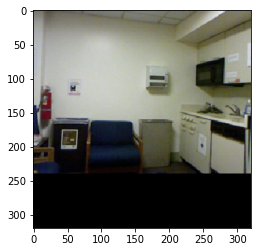

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(x_test[index])

In [0]:
normali_test_vis = (255/2.0 * (normali_test + 1)).astype(int)
normali_pred_vis = (255/2.0 * (y_test_p + 1)).astype(int)

Massimo: 253, minimo: 6


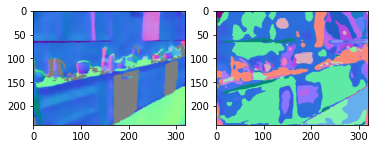

Massimo: 253, minimo: 6


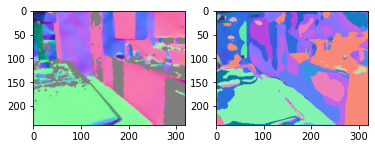

Massimo: 253, minimo: 6


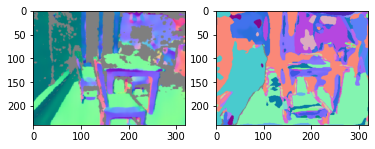

Massimo: 253, minimo: 6


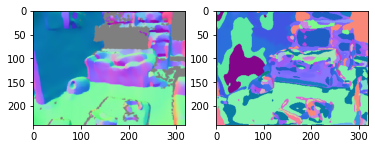

Massimo: 253, minimo: 6


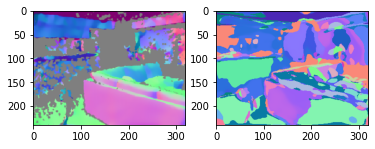

In [27]:
# visualizzo alcune coppie gt/predizione: 
%matplotlib inline
import matplotlib.pyplot as plt

rnd = np.sort(np.random.randint(y_test_p.shape[0], size=5))
for i in rnd:
  print("Massimo: {}, minimo: {}".format(np.max(normali_pred_vis[i]), np.min(normali_pred_vis[i])))
  plt.figure('gt/predicted')
  plt.subplot(121)
  plt.imshow(normali_test_vis[i])

  plt.subplot(122)
  plt.imshow(normali_pred_vis[i])
  plt.show()

# Valutazione

## Eval cosine

In [0]:
# pixel wise evaluation
# INPUT
# prediction:   shape = (1,3) normale predetta dalla rete (ottenuta come codifica dalle label)
# ground_truth: shape = (1,3) normale effettiva
# OUTPUT
# l'errore in radianti tra la normale passata e quella effettiva
def eval_cosine(prediction, ground_truth):
  if np.sum(ground_truth) == 0 or np.sum(prediction) == 0:
    return 0
  cosine = np.dot(prediction, ground_truth) / (np.linalg.norm(prediction) * np.linalg.norm(ground_truth))
  if (cosine <= 1 and cosine >= -1):
    return np.arccos(cosine) 
  return np.deg2rad(180) if cosine < -1 else 0

# questa funzione va chiamata su tutti i pixel di tutte le immagini del test-set o validation set.

In [0]:
def eval_cosine_img(img_y, img_gt):
  eval_cosine_img = np.zeros((240,320), dtype=np.float)
  for h in range(0, img_y.shape[0]):
    for w in range(0, img_y.shape[1]):
      eval_cosine_img[h][w] = eval_cosine(img_y[h][w], img_gt[h][w])
  return eval_cosine_img

In [0]:
def eval_cosine_all(yp, gt):
  eval_array = []
  for n in range(0,yp.shape[0]):
    eval_array.append(eval_cosine_img(yp[n, ], gt[n, ]))
  return np.asarray(eval_array)

In [0]:
eval_cosine_array = eval_cosine_all(y_test_p, normali_test[:y_test_p.shape[0], ])

In [32]:
eval_cosine_array.shape

(434, 240, 320)

In [33]:
print("In radianti Media: {:.2f}, varianza: {:.2f}".format(np.mean(eval_cosine_array), np.var(eval_cosine_array)))
print("In gradi Media: {:.2f}, varianza: {:.2f}".format(np.rad2deg(np.mean(eval_cosine_array)), np.rad2deg(np.var(eval_cosine_array))))

In radianti Media: 0.78, varianza: 0.40
In gradi Media: 44.50, varianza: 22.80


### Visualizzazione

In [0]:
eval_cosine_vis = (255/np.pi * eval_cosine_array).astype(int)

In [0]:
PLOTS_PATH = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/plots/sm_ft_4/'

In [0]:
selected_indexes = [304, 407, 135, 64, 325, 313, 238, 218, 112, 51]

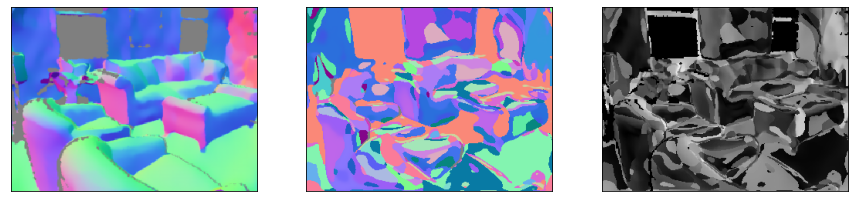

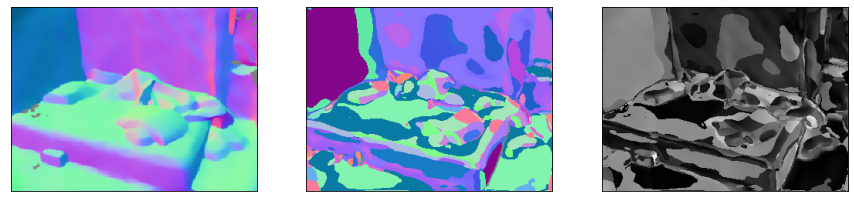

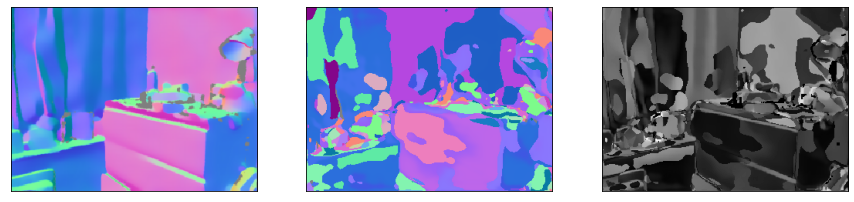

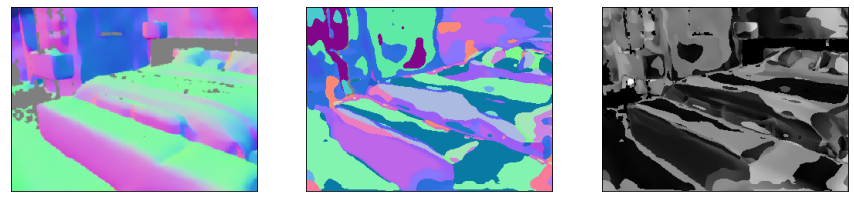

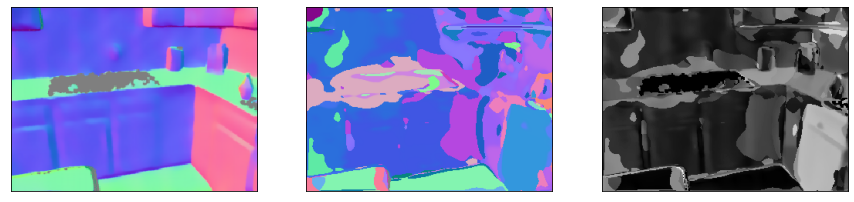

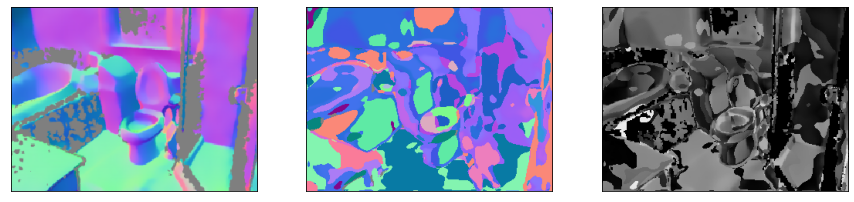

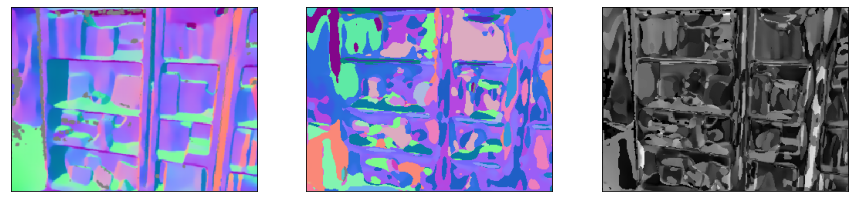

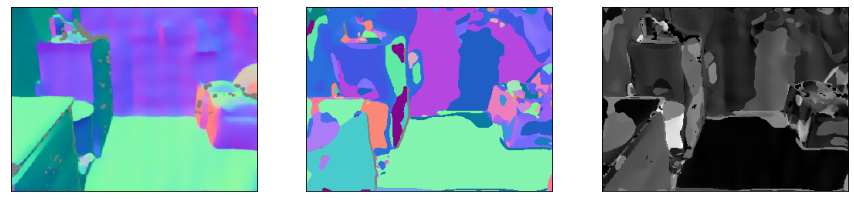

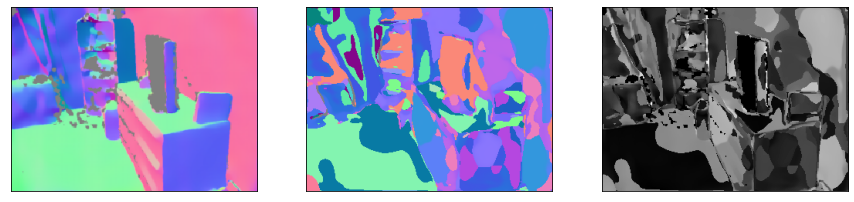

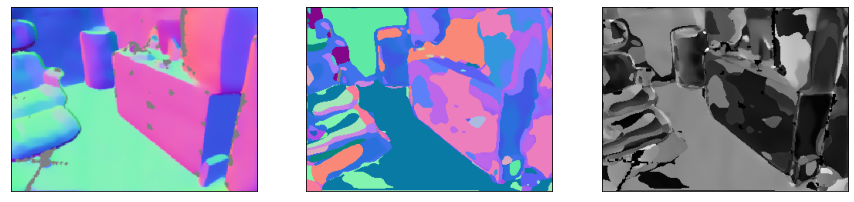

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

rnd = np.sort(np.random.randint(y_test_p.shape[0], size=20))
#for i in rnd:
for i in selected_indexes:
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  plt.setp(axs, xticks = [], yticks = [])
  axs[0].imshow(normali_test_vis[i])
  axs[1].imshow(normali_pred_vis[i])
  axs[2].imshow(eval_cosine_vis[i], cmap=plt.get_cmap('gray'))
  plt.savefig(PLOTS_PATH + "img" + str(i) + '.png')

## Soglia errori angolari rispetto a soglie

In [38]:
# TODO: effettuare la predizione su tutto il test-set (es: 30% del dataset "normals_orig.npy") con la rete. 
# Dopodichè decodificare le predizioni per ogni immagine (label -> normali 3d) e possibilmente salvare in un file (es: "prediction_test_decoded.npy").

# NOTA: nel calcolo della metrica non vanno considerati i pixel rumorosi, che sono identificati dalla tripla [0,0,0].
tot_noised_pixel = np.where(np.sum(normali_test, axis = -1) == 0)[0].shape[0]
tot_pixel = normali_test.shape[0] * normali_test.shape[1] * normali_test.shape[2]
valid_pixel = tot_pixel - tot_noised_pixel

theta = eval_cosine_array

print('Noised pixel / Tot pixel (%):', tot_noised_pixel / tot_pixel * 100)
print('Mean: ', np.rad2deg(np.sum(theta) / valid_pixel))

# es: carico da file
#theta = np.load(PATH_BASE + "prediction_test_decoded_20200513.npy")

# valuto la percentuale di errori angolari inferiori rispetto ad una delle seguenti soglie
soglie_errori = [11.25, 22.5, 30]
for th in soglie_errori:
  under_th = (np.where(theta < np.deg2rad(th))[0].shape[0] - tot_noised_pixel) / valid_pixel * 100
  print('Threshold', str(th),  under_th)

Noised pixel / Tot pixel (%): 10.729931715629801
Mean:  49.8484983399765
Threshold 11.25 15.350606633521297
Threshold 22.5 29.701431215181017
Threshold 30 37.41860678879044


In [0]:
ERRORS_PATH = '/content/drive/My Drive/Appunti delle lezioni/2Anno2Semestre/Digital Image Processing/errors/'
np.savez_compressed(ERRORS_PATH + "eval_cosine_sm4.npz", eval_cosine_array = eval_cosine_array)